<a href="https://colab.research.google.com/github/boffandre-cyber/PEE---2025/blob/main/C%C3%B3pia_de_C%C3%B3pia_de_TRB1_PEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ainda em falta:

*   ajustar os comentários durante o código (padronizar mais), escrever uma breve
*   introdução explicando objetivos,
*   colocar todas as bibliotecas que estão sendo usadas na primeira secção de código e explica-las no texto,
*   ajustar texto dos gráficos e alguns gráficos com subíndices e explicar cada parte,
*   fazer a parte de texto do reservatório
* Melhorar os atuais textos

Introdução
---
___

In [1]:
!git clone https://github.com/boffandre-cyber/PEE---2025.git

Cloning into 'PEE---2025'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 40 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 1.64 MiB | 9.74 MiB/s, done.
Resolving deltas: 100% (21/21), done.


Importando Biblitecas e suas funções
---
---
Esta secção de códogo é dedicada e importar todas as bibliotecas que serão utilizadas ao longo do projeto, sendo elas:
*   Pandas:
*   Numpy:
*   Matplotlib:



In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

Lendo o arquivo de dados
---
---
Inicialmente foi buscado um arquivo fluvial no site da ANA (Agencia Nacional das Águas) o qual está no formato csv, portanto deve-se ajusta-lo para a leitura correta pela Biblioteca Pandas, afim de fazer uma análise de dados posterior em forma de dataframe


In [ ]:
# Esta função é necessária para lidar com o formato específico do arquivo,
# que contém metadados antes do cabeçalho.
import re # Import the re module

def read_complex_csv(file_path):
    """
    Lê um arquivo CSV com metadados e retorna um DataFrame.
    """
    with open(file_path, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    # O cabeçalho está na linha 16 (índice 15).
    header_line = lines[15].strip()
    data_lines = lines[16:]

    # Obter os nomes das colunas, removendo aspas duplas.
    columns = [col.strip('"') for col in header_line.split(';')]

    # Processar as linhas de dados, removendo aspas e substituindo vírgulas por pontos.
    data = []
    for line in data_lines:
        if line.strip():  # Ignorar linhas vazias
            row = [re.sub(r'"', '', val).replace(',', '.') for val in line.split(';')]
            data.append(row)

    # Criar o DataFrame a partir dos dados processados.
    df = pd.DataFrame(data, columns=columns)

    # Remover colunas totalmente vazias ou sem nome
    df = df.dropna(axis=1, how='all')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    return df

# Substitua '70100000_Vazoes_I.csv' pelo nome do arquivo.
file_path = '70100000_Vazoes_I.csv'
df = read_complex_csv(file_path)

Análise de Dados
---
___
Análise inicial de dados onde é ajustado os dados de vazões para estar em conformidade com o estipulado como premissa em edital da disciplina. Nela também são ajustadas as colunas que inicialmente são entendidas como variáveis de String, portanto são ajustadas datas na forma de DateTime e vazões como Float

In [ ]:
# -----------------------------------------------------------------------------
# Início da análise
# -----------------------------------------------------------------------------

# Converter a coluna 'Data' para o formato de data
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

# Encontrar o ano mais recente nos dados
most_recent_year = df['Data'].dt.year.max()
print(f"Ano mais recente nos dados: {most_recent_year}")

# Definir o ano de corte para desconsiderar os dois últimos anos
year_cutoff = most_recent_year - 1
print(f"Os dados serão filtrados até o ano de: {year_cutoff - 1}")

# Filtrar o DataFrame para excluir os dois últimos anos
df_filtered = df[df['Data'].dt.year < year_cutoff].copy()

# Identificar as colunas de vazão, excluindo aquelas que contêm a palavra 'Status'
vazao_cols = [col for col in df_filtered.columns if 'Vazao' in col and 'Status' not in col]
print(f"\nColunas de vazão encontradas: {vazao_cols}")

# Desempilhar o DataFrame para obter uma única coluna com todos os valores de vazão
df_melted_filtered = df_filtered.melt(value_vars=vazao_cols, value_name='Vazao')

# Converter a coluna 'Vazao' para tipo numérico e remover valores ausentes
df_melted_filtered['Vazao'] = pd.to_numeric(df_melted_filtered['Vazao'], errors='coerce')
df_melted_filtered.dropna(subset=['Vazao'], inplace=True)

# Calcular a vazão média de longo termo
long_term_avg = df_melted_filtered['Vazao'].mean()

print(f"\nVazão média de longo termo (excluindo os dois últimos anos): {long_term_avg:.2f} m³/s")

# Definir o intervalo de referência e o valor alvo
lower_bound = 30
upper_bound = 60
target_avg = 45 # Ponto central do intervalo

# Verificar se a vazão média está fora do intervalo
if not (lower_bound <= long_term_avg <= upper_bound):
    print(f"\nA vazão média de longo termo está fora do intervalo [{lower_bound}, {upper_bound}] m³/s.")
    print("Aplicando fator de correção.")

    # Calcular o fator de correção
    correction_factor = target_avg / long_term_avg
    print(f"Fator de correção calculado: {correction_factor:.4f}")

    # Criar uma cópia do DataFrame original para aplicar a correção
    df_corrected = df.copy()

    # Aplicar o fator de correção a todas as colunas de vazão
    for col in vazao_cols:
        df_corrected[col] = pd.to_numeric(df_corrected[col], errors='coerce').mul(correction_factor)

    # Recalcular a média de longo termo com os dados corrigidos para verificação
    df_melted_corrected = df_corrected.melt(value_vars=vazao_cols, value_name='Vazao')
    df_melted_corrected['Vazao'] = pd.to_numeric(df_melted_corrected['Vazao'], errors='coerce')
    corrected_avg = df_melted_corrected['Vazao'].mean()
    print(f"Nova vazão média de longo termo após correção: {corrected_avg:.2f} m³/s")

    # Salvar o DataFrame corrigido em um novo arquivo CSV
    df_corrected.to_csv('70100000_Vazoes_I_Corrigido.csv', sep=';', index=False, decimal=',')
    print("\nUm novo arquivo CSV com os dados corrigidos foi gerado e está disponível como '70100000_Vazoes_I_Corrigido.csv'.")
else:
    print(f"\nA vazão média de longo termo já está dentro do intervalo [{lower_bound}, {upper_bound}] m³/s. Nenhuma correção é necessária.")


# Criando uma coluna de mediana:
#df_corrected['Mediana'] = df_corrected[vazao_cols].median(axis=1)

# Ajustantdo as colunas de media minima e maxima do df
df_corrected['Media'] = pd.to_numeric(df_corrected['Media'], errors='coerce')
df_corrected['Minima'] = pd.to_numeric(df_corrected['Minima'], errors='coerce')
df_corrected['Maxima'] = pd.to_numeric(df_corrected['Maxima'], errors='coerce')



for col in ['Media', 'Minima', 'Maxima']:
    df_corrected[col] = df_corrected[col] * correction_factor

# Criando uma coluna de mediana:
df_corrected['Mediana'] = df_corrected[vazao_cols].median(axis=1)

Plotagem dos Gráficos
---
___
Aqui são plotados os gráficos de vazões para o histórico de 40 anos. São feitos os gráficos da vazão média mensal e curva de carga para todo o histórico.
Também nesta secção se encontra a criação de um ano sintético o qual foi utilizado para fazer os gráficos das médias mensais e de Rippl.

In [ ]:
#grafico de vazao da média mensal de todos os anos
df_corrected


#plotando todos os valores de média
df_corrected.plot(x='Data', y='Media', kind='line')
plt.title('Vazão ao longo dos anos')
plt.xlabel('data')
plt.ylabel('vazão média')
plt.grid(True)
plt.show()

#aqui plotar sazonalidades fazer media das medias, das minimas e das maximas dos meses.
df_anosintetico = df_corrected
# Extrai o mês da data
df_anosintetico['Mes'] = df_anosintetico['Data'].dt.month

# Agrupa por mês e calcula a média das médias, minimas, máximas e medianas:
media_mensal_sintetica = df_anosintetico.groupby('Mes')['Media'].mean().reset_index()
media_minima_sintetica = df_anosintetico.groupby('Mes')['Minima'].mean().reset_index()
media_maxima_sintetica = df_anosintetico.groupby('Mes')['Maxima'].mean().reset_index()
mediana_mensal_sintetica = df_anosintetico.groupby('Mes')['Mediana'].mean().reset_index()

# Dicionário para converter número do mês em nome
meses = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}
media_mensal_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
media_minima_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
media_maxima_sintetica['MesNome'] = media_mensal_sintetica['Mes'].map(meses)
mediana_mensal_sintetica['MesNome'] = mediana_mensal_sintetica['Mes'].map(meses)

# Ordena corretamente os meses
media_mensal_sintetica = media_mensal_sintetica.sort_values('Mes')


# Junta os três DataFrames em um só, usando 'Mes' como chave
df_plot = media_mensal_sintetica[['Mes', 'Media']].copy()
df_plot['Minima'] = media_minima_sintetica['Minima']
df_plot['Maxima'] = media_maxima_sintetica['Maxima']
df_plot['MesNome'] = df_plot['Mes'].map(meses)

# Ordena corretamente os meses
df_plot = df_plot.sort_values('Mes')

# Plotagem
plt.figure(figsize=(12, 6))

# Faixa entre mínima e máxima
plt.fill_between(
    df_plot['MesNome'],
    df_plot['Minima'],
    df_plot['Maxima'],
    color='lightblue',
    alpha=0.4,
    label='Faixa (Mínima - Máxima)'
)

# Linha da média
plt.plot(df_plot['MesNome'], df_plot['Media'], marker='o', color='blue', label='Média Mensal')

# Linha da mínima
plt.plot(df_plot['MesNome'], df_plot['Minima'], linestyle='--', color='green', label='Média Mínima')

# Linha da máxima
plt.plot(df_plot['MesNome'], df_plot['Maxima'], linestyle='--', color='red', label='Média Máxima')

# Ajustes do gráfico
plt.title('Ano Sintético da Vazão Média Mensal (com Mínima e Máxima)')
plt.xlabel('Mês')
plt.ylabel('Vazão')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Plotando a média
plt.figure(figsize=(10, 5))

# Linha da média mensal
plt.plot(media_mensal_sintetica['MesNome'], media_mensal_sintetica['Media'],
         marker='o', color='blue', label='Média Mensal')

# Linha da mediana mensal
plt.plot(
    mediana_mensal_sintetica['MesNome'], mediana_mensal_sintetica['Mediana'],
    marker='s', color='red', linestyle='--', label='Mediana Mensal'
)

# Ajustes do gráfico
plt.title('Ano Sintético - Vazão Média Mensal')
plt.xlabel('Mês')
plt.ylabel('Vazão Média')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plota o gráfico de XXX
df_ordenado = df_corrected
df_ordenado['Media'] = sorted(df_ordenado['Media'])
df_corrected.plot(x='Data', y='Media', kind='line')
plt.title('Curva de XXXX')
plt.xlabel('variable')
plt.ylabel('vazão')
plt.grid(True)
plt.show()


Grafico de Rippl
---
___

### Reservatório



In [4]:
# ============================================================
# CÉLULA — Balanço mensal do reservatório
# Vf = Vi + ΔV_Q, onde ΔV_Q = round(Q_in - Q_out, 3) * dias * 24 * 60 * 60
# Cria VR = max(Vf) ao final
# ============================================================

import os
import numpy as np
import pandas as pd

def _to_float(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    return float(str(x).replace(',', '.'))

def _col(df, nome):
    alvo = nome.strip().lower()
    for k in df.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna obrigatória não encontrada: '{nome}'. Presentes: {list(df.columns)}")

# ---- entrada ----
ARQ = r"/content/PEE---2025/Reservatorio_1.xlsx"
if not os.path.exists(ARQ):
    raise FileNotFoundError(f"Arquivo não encontrado: {ARQ}")

df = pd.read_excel(ARQ)

# Normaliza números
for nome in ["Qsintética", "Qsaida"]:
    df[_col(df, nome)] = df[_col(df, nome)].map(_to_float)

# Dias (se não houver, usa calendário padrão)
dias_padrao = [31,28,31,30,31,30,31,31,30,31,30,31]
if any(cn.strip().lower() == "dias" for cn in df.columns):
    df["Dias"] = df[_col(df, "Dias")].map(_to_float)
else:
    df["Dias"] = pd.Series(dias_padrao[:len(df)])

# ---- balanço simples ----
CASAS_Q = 3  # arredondamento de Qliq (m³/s)
n = len(df)

Vi_list, Vf_list, Qliq_list, dV_Q_list = [], [], [], []

V_i = 0.0  # janeiro começa zerado
for i in range(n):
    Qin  = _to_float(df[_col(df, "Qsintética")].iloc[i])  # m³/s
    Qout = _to_float(df[_col(df, "Qsaida")].iloc[i])      # m³/s
    dias = float(df["Dias"].iloc[i])

    Qliq = round(Qin - Qout, CASAS_Q)               # m³/s
    dV_Q = Qliq * dias * 24 * 60 * 60               # m³
    V_f  = V_i + dV_Q                                # soma

    Vi_list.append(V_i);  Vf_list.append(V_f)
    Qliq_list.append(Qliq); dV_Q_list.append(dV_Q)

    V_i = V_f  # próximo mês começa em Vf

# ---- tabela final (somente balanço) ----
out = pd.DataFrame({
    "Mês": df[_col(df,"Mês")] if "Mês" in df.columns else np.arange(1, n+1),
    "Dias": df["Dias"].astype(int),
    "Q_in (m3/s)": df[_col(df,"Qsintética")].round(3),
    "Q_out (m3/s)": df[_col(df,"Qsaida")].round(3),
    "Qliq (m3/s)": np.array(Qliq_list).round(CASAS_Q),
    "ΔV_Q (m3)":   np.array(dV_Q_list).round(2),
    "Vi (m3)":     np.array(Vi_list).round(2),
    "Vf (m3)":     np.array(Vf_list).round(2),
})

# ---- VR: Volume do Reservatório = max(Vf) ----
VRu = float(out["Vf (m3)"].max() - out["Vf (m3)"].min() )
print(f"VRu (Volume Útil do Reservatório) = {VRu:,.2f} m³")

VRu (Volume Útil do Reservatório) = 54,341,366.40 m³


In [5]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

# ----------------- parâmetros -----------------
a = 45.0  # altura máxima (m)

# Entrada do usuário (Enter => usa Volume definido na célula anterior)
volume_minimo_operacao = 0.2
volume_reservatorio = VRu/(1-volume_minimo_operacao)
s = input(f"Informe o volume máximo do reservatório (m³) [padrão {volume_reservatorio:,.0f}]: ").strip()
vmax = float(s) if s else volume_reservatorio
if vmax <= 0:
    raise ValueError("O volume máximo deve ser positivo.")

# ----------------- cálculo de c e dimensões -----------------
# Vmax = 750 * c^2 * a  =>  c = sqrt(Vmax / (750*a))
c = math.sqrt(vmax / (750.0 * a))
w0 = 20.0 * c          # base menor (largura no z=0)
w1 = 40.0 * c          # base maior (largura no z=a)
D  = 25.0 * c          # profundidade (constante)
vmax_calc = 750.0 * (c**2) * a
# ----------------- impressão no console -----------------
print("\n=== RESULTADOS ===")
print(f"a = {a:.2f} m")
print(f"c = {c:.6f} m (fixo a partir de agora)")
print(f"Base menor (20c) = {w0:.3f} m, Base maior (40c) = {w1:.3f} m, Profundidade (25c) = {D:.3f} m")
print(f"Volume máximo informado = {vmax:,.3f} m³")
print(f"Volume máximo calculado (a partir de c) = {vmax_calc:,.3f} m³")


Informe o volume máximo do reservatório (m³) [padrão 67,926,708]: 

=== RESULTADOS ===
a = 45.00 m
c = 44.862492 m (fixo a partir de agora)
Base menor (20c) = 897.250 m, Base maior (40c) = 1794.500 m, Profundidade (25c) = 1121.562 m
Volume máximo informado = 67,926,708.000 m³
Volume máximo calculado (a partir de c) = 67,926,708.000 m³


In [11]:
# ============================================================
# CÉLULA — Balanço a partir de "Reservatorio_1.xlsx"
# Escolha: com OU sem precipitação/evaporação
# - Sem P/E: mantém lógica original (apenas vazões)
# - Com P/E: acrescenta (P - E) * Área_média(b) mês a mês (mm -> m)
# Saídas:
#   C:\Users\boffa\Downloads\TMP\BalancoReservatorio_semPE_.xlsx
#   C:\Users\boffa\Downloads\TMP\BalancoReservatorio_comPE_.xlsx
# (com fallback para salvar no diretório atual, útil no Colab)
# ============================================================

import os, math
import numpy as np
import pandas as pd

# ---------- checagens ----------
try:
    a, c
except NameError:
    raise RuntimeError("As variáveis 'a' e 'c' não existem. Rode as células anteriores primeiro.")

# ---------- pergunta ao usuário ----------
# Digite: S para rodar COM precipitação/evaporação; N para rodar SEM (apenas vazões)
try:
    escolha = input("Deseja considerar precipitação/evaporação? [S/N]: ").strip().upper()
except Exception:
    escolha = "N"
use_PE = (escolha == "S")

# ---------- caminhos ----------
ARQ_IN  = r"/content/PEE---2025/Reservatorio_1.xlsx"
OUT_DIR = r"/content/PEE---2025/"
OUT_SEM = os.path.join(OUT_DIR, "BalancoReservatorio_semPE_.xlsx")
OUT_COM = os.path.join(OUT_DIR, "BalancoReservatorio_comPE_.xlsx")

# fallbacks para Colab/ambientes sem acesso ao caminho do Windows
if not os.path.exists(ARQ_IN):
    # tentar arquivo enviado/na pasta atual
    cand = [p for p in os.listdir(".") if p.lower() == "reservatorio_1.xlsx"]
    if cand:
        ARQ_IN = cand[0]
        OUT_DIR = os.getcwd()
        OUT_SEM = os.path.join(OUT_DIR, "BalancoReservatorio_semPE_.xlsx")
        OUT_COM = os.path.join(OUT_DIR, "BalancoReservatorio_comPE_.xlsx")
    else:
        # tentar ambiente local de upload (ex.: /mnt/data)
        if os.path.exists("/mnt/data/Reservatorio_1.xlsx"):
            ARQ_IN = "/mnt/data/Reservatorio_1.xlsx"
            OUT_DIR = os.getcwd()
            OUT_SEM = os.path.join(OUT_DIR, "BalancoReservatorio_semPE_.xlsx")
            OUT_COM = os.path.join(OUT_DIR, "BalancoReservatorio_comPE_.xlsx")
        else:
            raise FileNotFoundError(
                "Não encontrei 'Reservatorio_1.xlsx'. "
                "Ajuste ARQ_IN ou coloque o arquivo na pasta do notebook."
            )

# ---------- leitura ----------
df = pd.read_excel(ARQ_IN)

def _to_float(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return float(x)
    # vírgula decimal -> ponto
    return float(str(x).replace(',', '.'))

def _col(df_, nome):
    alvo = nome.strip().lower()
    for k in df_.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna obrigatória não encontrada: '{nome}'. Presentes: {list(df.columns)}")

# colunas obrigatórias
col_mes = _col(df, "Mês") if any(c.strip().lower()=="mês" for c in df.columns) else None
col_qi  = _col(df, "Qsintética")
col_qo  = _col(df, "Qsaida")

# Evap e Prec são usados apenas se use_PE = True
col_ev, col_pr = None, None
if use_PE:
    col_ev = _col(df, "Evaporação")
    col_pr = _col(df, "Precipitação")

# Dias (se não houver, usa calendário padrão)
dias_padrao = [31,28,31,30,31,30,31,31,30,31,30,31]
if any(cn.strip().lower()=="dias" for cn in df.columns):
    col_dias = _col(df, "Dias")
    df["Dias"] = df[col_dias].map(_to_float)
else:
    df["Dias"] = pd.Series(dias_padrao[:len(df)])

# normaliza numéricos de vazões (m³/s)
df[col_qi] = df[col_qi].map(_to_float)
df[col_qo] = df[col_qo].map(_to_float)
if use_PE:
    df[col_ev] = df[col_ev].map(_to_float)  # mm
    df[col_pr] = df[col_pr].map(_to_float)  # mm

# ---------- geometria do reservatório ----------
Vmax = 750.0*(c**2)*a

def V_de_b(b):
    return 500.0*(c**2)*b + (250.0*(c**2)/a)*(b**2)

def b_de_V(V):
    # Inverso físico, clamp em [0, Vmax] para obter nível válido
    Vc = max(0.0, min(float(V), Vmax))
    A = 250.0*(c**2)/a
    B = 500.0*(c**2)
    C = -Vc
    disc = B*B - 4*A*C
    if disc < 0:  # numérico
        return 0.0
    r1 = (-B + math.sqrt(disc))/(2*A)
    r2 = (-B - math.sqrt(disc))/(2*A)
    return max(0.0, min(max(r1, r2, 0.0), a))

def A_lamina(b):
    return 500.0*(c**2)*(1.0 + b/a)

# ---------- balanço ----------
CASAS_Q = 3                 # arredondamento da vazão líquida para bater com sua planilha
seg_dia = 86400.0
n = len(df)

M_str = df[col_mes].astype(str).tolist() if col_mes else [f"Mês {i+1}" for i in range(n)]
Qi   = df[col_qi].astype(float).values
Qo   = df[col_qo].astype(float).values
Dias = df["Dias"].astype(float).values

Vi_list, Vf_list = [], []
bi_list, bf_list = [], []
Ai_list, Af_list = [], []
Qliq_list, dV_Q_list = [], []
dV_PE_list = []  # 0 no modo sem P/E
perc_list = []

V_i = 0.0  # janeiro começa zerado

for i in range(n):
    # Vazão líquida (m³/s), arredondada
    Qliq = round(Qi[i] - Qo[i], CASAS_Q)
    # Variação por vazões
    dV_Q = Qliq * Dias[i] * 24 * 60 * 60  # m³

    if not use_PE:
        # ------------- MODO SEM P/E (idêntico à lógica original solicitada) -------------
        V_f = V_i + dV_Q
        b_i = b_de_V(V_i); A_i = A_lamina(b_i)
        b_f = b_de_V(V_f); A_f = A_lamina(V_f) # Fixed: use V_f to calculate A_f
        dV_PE = 0.0
    else:
        # ------------- MODO COM P/E -------------
        # mm -> m
        E_m = 0.001 * max(_to_float(df[col_ev].iloc[i]), 0.0)  # evaporação (m)
        P_m = 0.001 * max(_to_float(df[col_pr].iloc[i]), 0.0)  # precipitação (m)

        # área no início
        b_i = b_de_V(V_i); A_i = A_lamina(b_i)

        # iteração de ponto fixo usando A_média = (A_i + A_f)/2
        V_guess = V_i + dV_Q + (P_m - E_m) * A_i
        for _ in range(30):
            b_f = b_de_V(V_guess)
            A_f = A_lamina(b_f)
            A_med = 0.5*(A_i + A_f)
            V_new = V_i + dV_Q + (P_m - E_m) * A_med
            if abs(V_new - V_guess) <= 1e-9 * max(1.0, abs(V_new)):
                V_guess = V_new
                break
            V_guess = V_new

        V_f = V_guess
        # valores finais
        b_f = b_de_V(V_f); A_f = A_lamina(b_f)
        dV_PE = (P_m - E_m) * 0.5*(A_i + A_f)

    # guarda
    Vi_list.append(V_i); Vf_list.append(V_f)
    bi_list.append(b_i); bf_list.append(b_f)
    Ai_list.append(A_i); Af_list.append(A_f)
    Qliq_list.append(Qliq); dV_Q_list.append(dV_Q)
    dV_PE_list.append(dV_PE)

    # % do volume em relação ao volume total (usando volume físico do nível b_f)
    V_phys_f = V_de_b(bf_list[-1])
    perc_list.append(100.0 * V_phys_f / Vmax if Vmax > 0 else np.nan)

    # Próximo mês
    V_i = V_f

# ---------- tabela de saída ----------
out = pd.DataFrame({
    "Mês": M_str,
    "Dias": np.array(Dias).astype(int),
    "Q_in (m3/s)": np.round(Qi, 3),
    "Q_out (m3/s)": np.round(Qo, 3),
    "Qliq (m3/s)": np.round(Qliq_list, CASAS_Q),
    "ΔV_Q (m3)":   np.round(dV_Q_list, 2),
    "ΔV_(P-E) (m3)": np.round(dV_PE_list, 2),
    "Vi (m3)":     np.round(Vi_list, 2),
    "Vf (m3)":     np.round(Vf_list, 2),
    "b_i (m)":     np.round(bi_list, 3),
    "b_f (m)":     np.round(bf_list, 3),
    "A_i (m2)":    np.round(Ai_list, 2),
    "A_f (m2)":    np.round(Af_list, 2),
    "% Volume [%]": np.round(perc_list, 2),
})

# ---------- salvar Excel ----------
destino = OUT_COM if use_PE else OUT_SEM
try:
    os.makedirs(os.path.dirname(destino), exist_ok=True)
    out.to_excel(destino, index=False)
    print(("Rodando COM P/E → " if use_PE else "Rodando SEM P/E → ") +
          f"arquivo salvo em: {destino}")
except Exception:
    # fallback: salvar no diretório atual
    destino = os.path.join(os.getcwd(), os.path.basename(destino))
    out.to_excel(destino, index=False)
    print(("Rodando COM P/E → " if use_PE else "Rodando SEM P/E → ") +
          f"salvei no diretório atual: {destino}")

# ---------- exibir tabela ----------
out

Deseja considerar precipitação/evaporação? [S/N]: n
Rodando SEM P/E → arquivo salvo em: /content/PEE---2025/BalancoReservatorio_semPE_.xlsx


,Mês,Dias,Q_in (m3/s),Q_out (m3/s),Qliq (m3/s),ΔV_Q (m3),ΔV_(P-E) (m3),Vi (m3),Vf (m3),b_i (m),b_f (m),A_i (m2),A_f (m2),% Volume [%]
0,Jan,31,34.6,27.267,7.333,19640707.2,0.0,0.0,19640707.2,0.000,16.494,1006321.60,4.392203e+11,28.91
1,Fev,28,38.8,27.267,11.533,27900633.6,0.0,19640707.2,47541340.8,16.494,34.227,1375180.62,1.063154e+12,69.99
2,Mar,31,27.4,27.267,0.133,356227.2,0.0,47541340.8,47897568.0,34.227,34.427,1771719.18,1.071120e+12,70.51
3,Abr,30,19.0,27.267,-8.267,-21428064.0,0.0,47897568.0,26469504.0,34.427,21.274,1776209.80,5.919306e+11,38.97
4,Mai,31,22.1,27.267,-5.167,-13839292.8,0.0,26469504.0,12630211.2,21.274,11.166,1482073.69,2.824467e+11,18.59
5,Jun,30,21.7,27.267,-5.567,-14429664.0,0.0,12630211.2,-1799452.8,11.166,0.000,1256015.31,-4.023962e+10,0.00
6,Jul,31,29.3,27.267,2.033,5445187.2,0.0,-1799452.8,3645734.4,0.000,3.488,1006321.60,8.152948e+10,5.37
7,Ago,31,23.5,27.267,-3.767,-10089532.8,0.0,3645734.4,-6443798.4,3.488,0.000,1084315.50,-1.440997e+11,0.00
8,Set,30,27.5,27.267,0.233,603936.0,0.0,-6443798.4,-5839862.4,0.000,0.000,1006321.60,-1.305941e+11,0.00
9,Out,31,33.8,27.267,6.533,17497987.2,0.0,-5839862.4,11658124.8,0.000,10.386,1006321.60,2.607082e+11,17.16


Considerar precipitação/evaporação? [S/N]: s
GIF salvo em: /content/PEE---2025/Reservatorio_VolumeAnim_comPE.gif


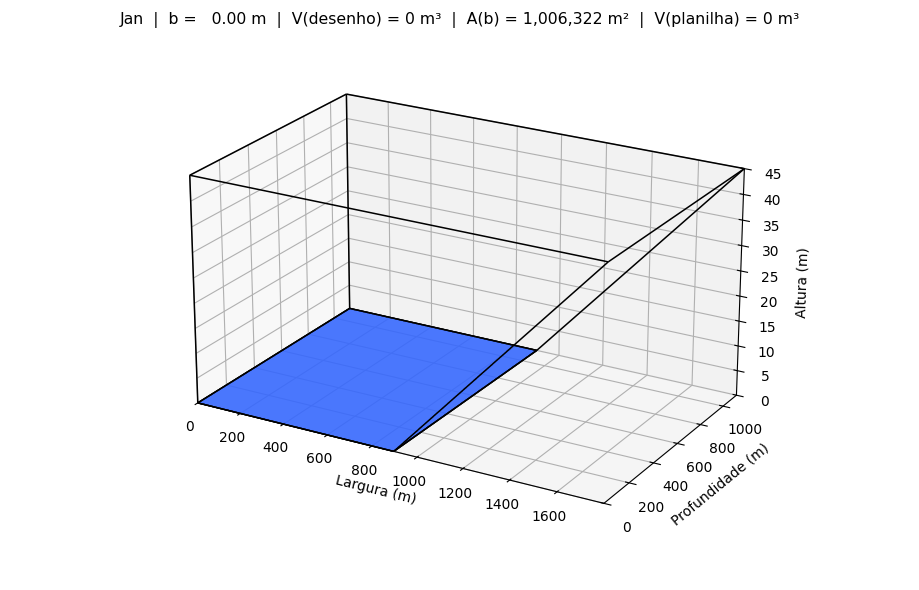


Sem vertimento: nenhum mês excedeu Vmax.


In [13]:
# ============================================================
# Animação + detecção de vertimento (mesmo visual de antes)
# Agora com escolha COM/SEM precipitação/evaporação
# Requisitos: 'a' e 'c' definidos; planilhas geradas:
#   - C:\Users\boffa\Downloads\TMP\BalancoReservatorio_semPE_.xlsx
#   - C:\Users\boffa\Downloads\TMP\BalancoReservatorio_comPE_.xlsx
# ============================================================

import os, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from IPython.display import Image, display

# ---------- checagens ----------
try:
    a, c
except NameError:
    raise RuntimeError("As variáveis 'a' e 'c' não existem. Rode a célula que as define.")

# ---------- escolha COM/SEM P-E ----------
try:
    resp = input("Considerar precipitação/evaporação? [S/N]: ").strip().upper()
except Exception:
    resp = "N"
USE_PE = (resp == "S")

# ---------- caminhos ----------
BASE = r"/content/PEE---2025/"
ARQ = os.path.join(BASE, "BalancoReservatorio_comPE_.xlsx" if USE_PE
                          else "BalancoReservatorio_semPE_.xlsx")
GIF_PATH = os.path.join(BASE, f"Reservatorio_VolumeAnim_{'comPE' if USE_PE else 'semPE'}.gif")

# fallbacks (Colab/Jupyter): procurar na pasta atual
if not os.path.exists(ARQ):
    alt = [p for p in os.listdir(".")
           if p.lower().endswith(".xlsx")
           and "balancoreservatorio" in p.lower()
           and (("compe" in p.lower()) == USE_PE)]
    if alt:
        ARQ = alt[0]
        GIF_PATH = os.path.join(os.getcwd(), f"Reservatorio_VolumeAnim_{'comPE' if USE_PE else 'semPE'}.gif")
    else:
        raise FileNotFoundError(
            "Não encontrei a planilha esperada. Gere-a na célula anterior ou ajuste o caminho 'ARQ'."
        )

# ---------- leitura ----------
dfb = pd.read_excel(ARQ)
def _col(df, nome):
    alvo = nome.strip().lower()
    for k in df.columns:
        if k.strip().lower() == alvo:
            return k
    raise KeyError(f"Coluna '{nome}' não encontrada. Colunas: {list(df.columns)}")

col_Vi = _col(dfb, "Vi (m3)")
col_Vf = _col(dfb, "Vf (m3)")
Vi = dfb[col_Vi].astype(float).values
Vf = dfb[col_Vf].astype(float).values
if any(c.strip().lower()=="mês" for c in dfb.columns):
    col_MES = _col(dfb, "Mês")
    meses_labels = dfb[col_MES].astype(str).tolist()
else:
    meses_labels = [f"Mês {i+1}" for i in range(len(Vi))]

nmes = len(Vi)

# ---------- geometria (igual) ----------
w0, w1, D = 20.0*c, 40.0*c, 25.0*c
Vmax = 750.0*(c**2)*a

def largura(z):        return 20.0*c*(1.0 + z/a)
def V_de_b(b):         return 500.0*(c**2)*b + (250.0*(c**2)/a)*(b**2)
def b_de_V(V):
    # inverso de V(b); usamos clamp para desenhar
    A = 250.0*(c**2)/a; B = 500.0*(c**2); C = -max(0.0, min(V, Vmax))
    disc = B*B - 4*A*C
    if disc < 0: return 0.0
    r1 = (-B + math.sqrt(disc)) / (2*A)
    r2 = (-B - math.sqrt(disc)) / (2*A)
    return max(0.0, min(max(r1, r2, 0.0), a))
def A_lamina(b):       return 500.0*(c**2)*(1.0 + b/a)

# ---------- vertimento por mês ----------
extravaso = np.maximum(Vf - Vmax, 0.0)   # m³ acima da capacidade no fim do mês
tem_vert = extravaso > 0
total_extravaso = float(extravaso.sum())

# ---------- trajetória Vi→Vf (igual) ----------
FRAMES_POR_MES = 8   # suavidade (4–12)
FPS = 8

V_traj = []
mes_idx_for_frame = []
for i in range(nmes):
    v0, v1 = float(Vi[i]), float(Vf[i])
    for t in np.linspace(0.0, 1.0, FRAMES_POR_MES, endpoint=False):
        V_traj.append((1.0 - t)*v0 + t*v1)
        mes_idx_for_frame.append(i)
# último frame no fim do último mês
V_traj.append(float(Vf[-1]))
mes_idx_for_frame.append(nmes - 1)
N = len(V_traj)

# ---------- casco do reservatório (igual) ----------
bottom = [(0, 0, 0), (w0, 0, 0), (w0, D, 0), (0, D, 0)]
top    = [(0, 0, a), (w1, 0, a), (w1, D, a), (0, D, a)]
edges_res = [
    [bottom[0], bottom[1]], [bottom[1], bottom[2]], [bottom[2], bottom[3]], [bottom[3], bottom[0]],
    [top[0], top[1]], [top[1], top[2]], [top[2], top[3]], [top[3], top[0]],
    [bottom[0], top[0]], [bottom[1], top[1]], [bottom[2], top[2]], [bottom[3], top[3]],
]
def faces_agua_from_b(b):
    wb = largura(b)
    top_b = [(0, 0, b), (wb, 0, b), (wb, D, b), (0, D, b)]
    return [
        bottom, top_b,
        [bottom[0], bottom[1], top_b[1], top_b[0]],
        [bottom[1], bottom[2], top_b[2], top_b[1]],
        [bottom[2], bottom[3], top_b[3], top_b[2]],
        [bottom[3], bottom[0], top_b[0], top_b[3]],
    ]

# ---------- figura e animação (igual) ----------
FIGSIZE = (9.2, 5.9)
VERTICAL_EXAG = 0.65     # mantenho o mesmo comportamento visual que você aprovou

fig = plt.figure(figsize=FIGSIZE, constrained_layout=True)
ax  = fig.add_subplot(111, projection='3d')

poly_agua = Poly3DCollection(faces_agua_from_b(0.0), alpha=0.65, edgecolor='k')
poly_agua.set_facecolor((0.2, 0.4, 1.0, 0.65))
ax.add_collection3d(poly_agua)
ax.add_collection3d(Line3DCollection(edges_res, linewidths=1.1, colors='k'))

ax.set_xlim(0, max(w0, w1)); ax.set_ylim(0, D); ax.set_zlim(0, a)
ax.set_xlabel('Largura (m)'); ax.set_ylabel('Profundidade (m)'); ax.set_zlabel('Altura (m)')
ax.view_init(elev=22, azim=-60)

bx, by = max(w0, w1), D
bz = max(a, VERTICAL_EXAG*(bx+by)/2)
ax.set_box_aspect((bx, by, bz))

def set_header(V_planilha, mes_idx):
    # clamp para desenhar
    Vc = max(0.0, min(V_planilha, Vmax))
    b  = b_de_V(Vc)
    titulo = (f"{meses_labels[mes_idx]}  |  b = {b:6.2f} m"
              f"  |  V(desenho) = {V_de_b(b):,.0f} m³"
              f"  |  A(b) = {A_lamina(b):,.0f} m²"
              f"  |  V(planilha) = {V_planilha:,.0f} m³")
    if extravaso[mes_idx] > 0:
        titulo += f"  |  **VERTIMENTO: {extravaso[mes_idx]:,.0f} m³**"
    fig.suptitle(titulo, fontsize=11.3, y=0.98)

def init():
    set_header(V_traj[0], mes_idx_for_frame[0])
    b = b_de_V(max(0.0, min(V_traj[0], Vmax)))
    poly_agua.set_verts(faces_agua_from_b(b))
    return (poly_agua,)

def update(i):
    V_now = V_traj[i]
    mi = mes_idx_for_frame[i]
    Vc = max(0.0, min(V_now, Vmax))
    b  = b_de_V(Vc)
    poly_agua.set_verts(faces_agua_from_b(b))
    set_header(V_now, mi)
    return (poly_agua,)

anim = animation.FuncAnimation(fig, update, init_func=init, frames=N, interval=int(1000/FPS), blit=True)

# ---------- salvar GIF e exibir ----------
try:
    os.makedirs(os.path.dirname(GIF_PATH), exist_ok=True)
except Exception:
    GIF_PATH = os.path.join(os.getcwd(), f"Reservatorio_VolumeAnim_{'comPE' if USE_PE else 'semPE'}.gif")

anim.save(GIF_PATH, writer=animation.PillowWriter(fps=FPS))
plt.close(fig)
print(f"GIF salvo em: {GIF_PATH}")
display(Image(filename=GIF_PATH))

# ---------- mensagens de vertimento ----------
if tem_vert.any():
    print("\n>>> VERTIMENTO DETECTADO:")
    for i, extr in enumerate(extravaso):
        if extr > 0:
            print(f"- {meses_labels[i]}: extravaso = {extr:,.2f} m³ (Vf={Vf[i]:,.2f} > Vmax={Vmax:,.2f})")
    print(f"Total extravasado no ano: {total_extravaso:,.2f} m³")
else:
    print("\nSem vertimento: nenhum mês excedeu Vmax.")